Mounted at /content/drive


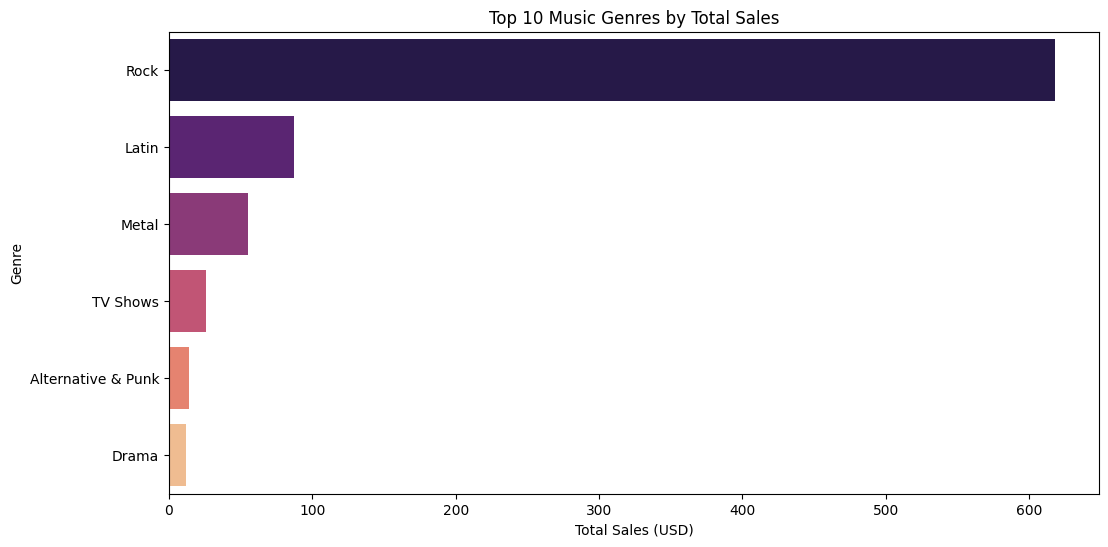

✅ 1. ดึงข้อมูลจาก Google Drive และวิเคราะห์สำเร็จ!
✅ 2. อัปเดตข้อมูลเข้า Google Sheets สำเร็จ!
🔗 ชื่อไฟล์ใน Sheets: Global_Music_Sales_Project_Final
🚀 ขั้นตอนต่อไป: ไปที่ Looker Studio แล้วเพิ่ม 'Country' เป็นแผนที่ และ 'Genre' เป็นกราฟวงกลมได้เลย!


In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth, drive
import gspread
from google.auth import default

# --- Section 0: Environment Setup ---
# Mount Google Drive to access SQLite database
drive.mount('/content/drive')
db_path = "/content/drive/MyDrive/My project/Chinook_Sqlite.sqlite"

try:
    # --- Section 1: Data Extraction via SQL Complex Join ---
    conn = sqlite3.connect(db_path)

    # Query to join Customer, Invoice, Track, and Genre tables
    query = """
    SELECT
        c.FirstName || ' ' || c.LastName AS FullName,
        c.Country,
        g.Name AS Genre,
        SUM(il.UnitPrice * il.Quantity) AS Total_Sales,
        COUNT(DISTINCT i.InvoiceId) AS Order_Count
    FROM Invoice i
    JOIN Customer c ON i.CustomerId = c.CustomerId
    JOIN InvoiceLine il ON i.InvoiceId = il.InvoiceId
    JOIN Track t ON il.TrackId = t.TrackId
    JOIN Genre g ON t.GenreId = g.GenreId
    GROUP BY 1, 2, 3
    ORDER BY Total_Sales DESC
    LIMIT 50
    """

    df = pd.read_sql_query(query, conn)
    conn.close()

    # --- Section 2: Data Visualization (Exploratory Data Analysis) ---
    plt.figure(figsize=(12, 6))
    genre_sales = df.groupby('Genre')['Total_Sales'].sum().sort_values(ascending=False).head(10)
    sns.barplot(x=genre_sales.values, y=genre_sales.index, hue=genre_sales.index, palette='magma', legend=False)
    plt.title('Sales Distribution by Music Genre')
    plt.xlabel('Total Sales (USD)')
    plt.show()

    # --- Section 3: Data Export to Google Sheets for BI Tools ---

    # Authenticate Google Sheets API
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Manage Google Spreadsheet session
    sh_name = 'Global_Music_Sales_Project_Final'
    try:
        sh = gc.open(sh_name)
    except:
        sh = gc.create(sh_name)

    worksheet = sh.get_worksheet(0)

    # Push processed data to Spreadsheet
    worksheet.clear()
    worksheet.update([df.columns.values.tolist()] + df.values.tolist())

    print(f"✅ Pipeline Execution Successful: Data synced to {sh_name}")

except Exception as e:
    print(f"❌ Execution Error: {e}")